The NBA data has already been combined into a single dataframe and cleaned up.  In this notebook I will investigate which columns have strong correlations with the '2019-20' column.  This column is the amount a player will make in the 2019-20 season and is a better value to try and predict than 'Guaranteed' since 'Guaranteed' will vary with the length of the contract.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns # For all our visualization needs.
import statsmodels.api as sm # Cross-sectional models and methods used for regression.
from statsmodels.graphics.api import abline_plot # Plot a line given an intercept and slope.
from sklearn.metrics import mean_squared_error, r2_score # Mean squared error regression loss, R**2 (coefficient of determination) regression score function.
from sklearn.model_selection import train_test_split #  Split arrays or matrices into random train and test subsets.
from sklearn import linear_model, preprocessing # Ordinary least squares Linear Regression, provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_csv('NBA clean data', index_col=0)
df.head()

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,BLK,TOV,PF,PTS,2019-20,Signed Using,Guaranteed,Team,Team_Value,Market Size
118,Aaron Gordon,PF,25,19,19,552,5.9,13.9,0.427,2.0,...,1.0,3.5,2.5,17.1,19863636.00 $,Bird Rights,54409091.00 $,ORL,1.460,small
277,Aaron Holiday,PG,24,29,6,576,5.1,13.7,0.370,1.9,...,0.2,1.4,3.1,13.4,2239200.00 $,1st Round Pick,4584840.00 $,IND,1.550,small
31,Abdel Nader,SF,27,12,0,172,6.5,13.0,0.500,2.1,...,0.2,1.7,2.7,18.0,1618520.00 $,Cap Space,1618520.00 $,OKC,1.575,medium
364,Al Horford,C,34,19,19,536,7.5,16.6,0.453,2.8,...,1.1,1.6,2.2,18.7,28000000.00 $,Cap Space,97000000.00 $,PHI,2.075,medium
109,Al-Farouq Aminu,PF,30,2,0,16,2.3,2.3,1.000,2.3,...,0.0,4.5,0.0,6.8,9258000.00 $,MLE,29162700.00 $,ORL,1.460,small


In [3]:
# Remove 'Guaranteed' since I'll be focusing on '2019-20'
df = df.drop('Guaranteed', 1)

# Remove 'Team' since the column 'Team_Value' has the important information
df = df.drop('Team', 1)

df.head()

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,AST,STL,BLK,TOV,PF,PTS,2019-20,Signed Using,Team_Value,Market Size
118,Aaron Gordon,PF,25,19,19,552,5.9,13.9,0.427,2.0,...,5.2,0.9,1.0,3.5,2.5,17.1,19863636.00 $,Bird Rights,1.460,small
277,Aaron Holiday,PG,24,29,6,576,5.1,13.7,0.370,1.9,...,3.3,0.9,0.2,1.4,3.1,13.4,2239200.00 $,1st Round Pick,1.550,small
31,Abdel Nader,SF,27,12,0,172,6.5,13.0,0.500,2.1,...,2.3,1.0,0.2,1.7,2.7,18.0,1618520.00 $,Cap Space,1.575,medium
364,Al Horford,C,34,19,19,536,7.5,16.6,0.453,2.8,...,4.6,1.2,1.1,1.6,2.2,18.7,28000000.00 $,Cap Space,2.075,medium
109,Al-Farouq Aminu,PF,30,2,0,16,2.3,2.3,1.000,2.3,...,4.5,0.0,0.0,4.5,0.0,6.8,9258000.00 $,MLE,1.460,small


In [4]:
# Get some basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 118 to 78
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        402 non-null    object 
 1   Pos           402 non-null    object 
 2   Age           402 non-null    int64  
 3   G             402 non-null    int64  
 4   GS            402 non-null    int64  
 5   MP            402 non-null    int64  
 6   FG            402 non-null    float64
 7   FGA           402 non-null    float64
 8   FG%           402 non-null    float64
 9   3P            402 non-null    float64
 10  3PA           402 non-null    float64
 11  3P%           402 non-null    float64
 12  2P            402 non-null    float64
 13  2PA           402 non-null    float64
 14  2P%           402 non-null    float64
 15  FT            402 non-null    float64
 16  FTA           402 non-null    float64
 17  FT%           402 non-null    float64
 18  ORB           402 non-null   

In [5]:
# remove the '$' from the 2019-20 column, strip the extra space at the end, and change to numeric dtype
no_sym = df['2019-20'].str.replace('$', '')
no_space = no_sym.str.strip()
df['2019-20'] = pd.to_numeric(no_space)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 118 to 78
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        402 non-null    object 
 1   Pos           402 non-null    object 
 2   Age           402 non-null    int64  
 3   G             402 non-null    int64  
 4   GS            402 non-null    int64  
 5   MP            402 non-null    int64  
 6   FG            402 non-null    float64
 7   FGA           402 non-null    float64
 8   FG%           402 non-null    float64
 9   3P            402 non-null    float64
 10  3PA           402 non-null    float64
 11  3P%           402 non-null    float64
 12  2P            402 non-null    float64
 13  2PA           402 non-null    float64
 14  2P%           402 non-null    float64
 15  FT            402 non-null    float64
 16  FTA           402 non-null    float64
 17  FT%           402 non-null    float64
 18  ORB           402 non-null   

In [7]:
# Change the 2019-20 salary information to millions of dollars for easier comparison
df['Salary (millions)'] = df['2019-20'] / 1000000
del df['2019-20']

In [8]:
# Look at the difference in salary between different positions
df.groupby('Pos')['Salary (millions)'].describe()

,count,mean,std,min,25%,50%,75%,max
Pos,,,,,,,,
C,80.0,9.080154,9.012455,0.050752,2.358894,4.767000,14.603932,28.000000
F,1.0,2.000000,NaN,2.000000,2.000000,2.000000,2.000000,2.000000
F-C,1.0,0.350189,NaN,0.350189,0.350189,0.350189,0.350189,0.350189
G,2.0,3.704315,5.109211,0.091557,1.897936,3.704315,5.510694,7.317073
PF,83.0,8.176715,9.482257,0.144901,1.797651,3.623000,10.550610,37.199000
PG,69.0,10.321329,11.966931,0.050752,1.588231,6.273000,12.428571,40.231758
SF,67.0,7.102997,9.423865,0.050752,1.416852,2.281800,8.588076,33.005556
SF-PF,1.0,1.699236,NaN,1.699236,1.699236,1.699236,1.699236,1.699236
SG,98.0,7.490125,8.612363,0.155647,1.952250,3.637980,10.075000,37.800000


Some new issues with the data have been identified.  Some players have multiple positions listed so I will need to change the entries that aren't PG, SG, SF, PF, or C.  There are only 5 such cases, so they can be handled rather easily.  To make sure the positions are assigned correctly, the players will be identified and a quick Google search should show their primary position.

In [9]:
p1 = df[df['Pos'] == 'F']['Player']
p2 = df[df['Pos'] == 'F-C']['Player']
p3_4 = df[df['Pos'] == 'G']['Player']
p5 = df[df['Pos'] == 'SF-PF']['Player']
print(p1, p2, p3_4, p5)

225    Noah Vonleh
Name: Player, dtype: object 368    Norvel Pelle
Name: Player, dtype: object 399    Chasson Randle
330      Derrick Rose
Name: Player, dtype: object 101    Rodions Kurucs
Name: Player, dtype: object


Noah Vonleh and Norvel Pelle both seem to play primarily as PFs.  Chasson Randle and Derrick Rose are PGs.  Rodions Kurucs was listed as PF for 2019-20.  Now these values will be changed and .describe() can be used again.

In [10]:
df.at[[225, 368, 101], 'Pos'] = 'PF'
df.at[[399, 330], 'Pos'] = 'PG'

df.groupby('Pos')['Salary (millions)'].describe()

,count,mean,std,min,25%,50%,75%,max
Pos,,,,,,,,
C,80.0,9.080154,9.012455,0.050752,2.358894,4.767000,14.603932,28.000000
PF,86.0,7.938567,9.399230,0.144901,1.740359,3.505771,9.789360,37.199000
PG,71.0,10.134934,11.861892,0.050752,1.516964,6.273000,12.387125,40.231758
SF,67.0,7.102997,9.423865,0.050752,1.416852,2.281800,8.588076,33.005556
SG,98.0,7.490125,8.612363,0.155647,1.952250,3.637980,10.075000,37.800000


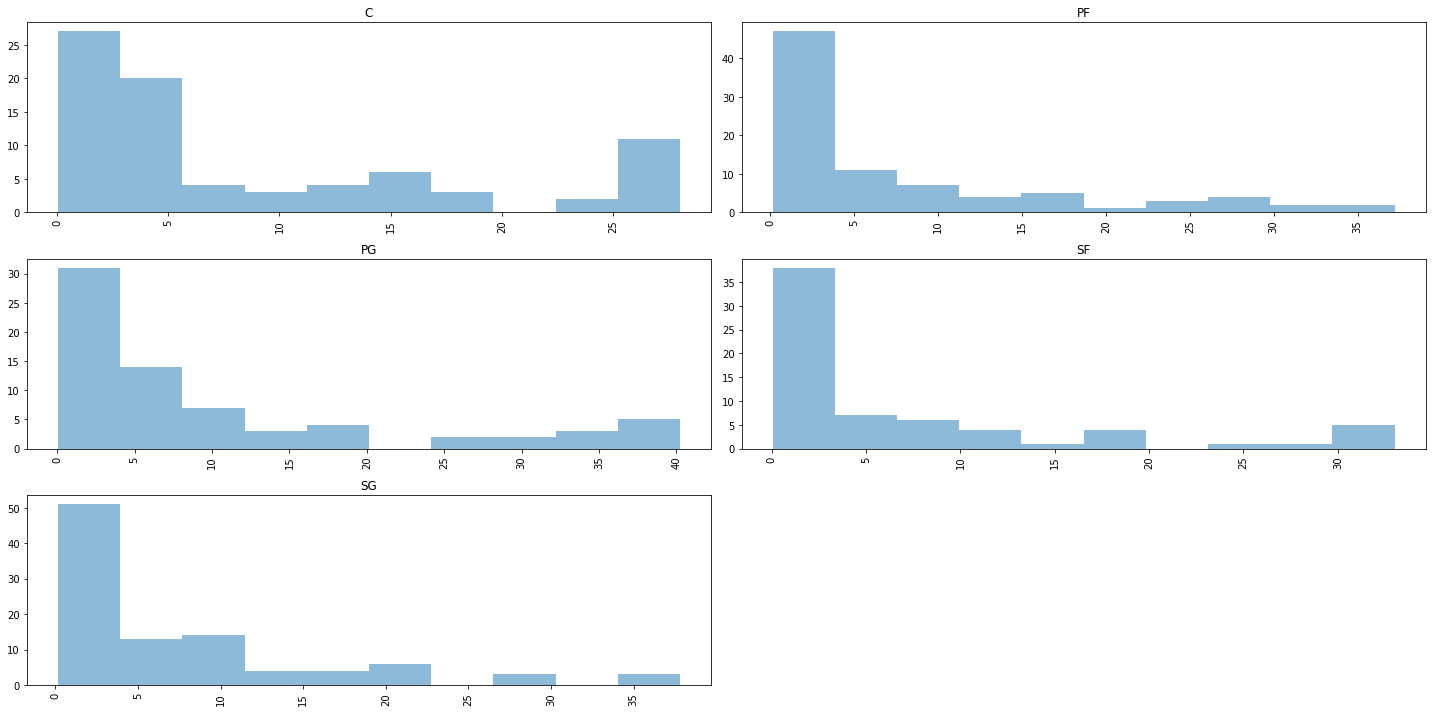

In [11]:
df['Salary (millions)'].hist(by=df['Pos'], alpha=0.5, figsize=(20,10));
plt.tight_layout();
plt.show()

The histograms show that the salary in each position is not normally distributed.  In every position, the distribution has a long tail to the right.  This makes sense, since there are a few superstars that make tons of money whereas the majority of players make a lower salary.

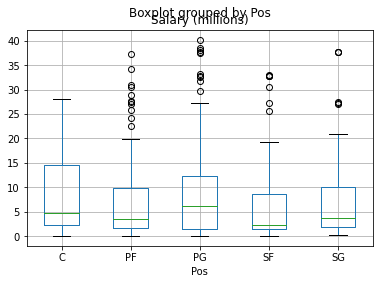

In [12]:
df.boxplot(column=['Salary (millions)'], by='Pos');

Though there is some variation based on position, overall there are no large differences in the range of salaries for each position.

A good place to start, regardless of position, seems to be PTS.  Regardless of what position a player plays, we would expect a high scoring player to be paid more than a low scoring player.  Time to put that to the test.

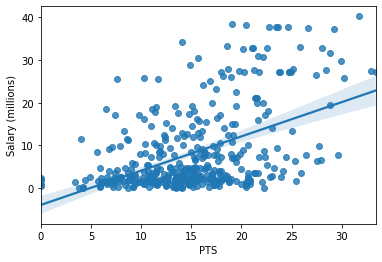

In [13]:
sns.regplot(x='PTS', y='Salary (millions)', data=df);

While there is a positive correlation, there is a dense cluster of lower salaries for players scoring between 5 and 20 points per game.  Since we are dealing with per 36 stats, the amount of game time each player plays is taken out of the process.  One possible explanation for the dense cluster is that players who do not play much but score a few points when they do play are being represented as high scorers in their per 36 stats.  An example of this is a player who only goes in for the last 6 minutes of a game when his team is already winning by a lot.  He may score 3 points in that time, giving him a per 36 PTS stat of 18.

To deal with this, we can look at the distribution of MP (minutes played) and G (games) so we can eliminate players who did not play very much and may have per36 stats that don't represent their actual value.

In [14]:
mins = df['MP'].describe()
games = df['G'].describe()
print(mins, games)

count     402.000000
mean      469.982587
std       287.502683
min         6.000000
25%       227.750000
50%       474.500000
75%       698.750000
max      1101.000000
Name: MP, dtype: float64 count    402.000000
mean      19.987562
std        7.765089
min        1.000000
25%       14.000000
50%       22.000000
75%       27.000000
max       30.000000
Name: G, dtype: float64


In [15]:
# Only look at the top 75% of players for minutes played
df = df[df['MP'] >= 227.75]

# Only look at players who have played in at least 14 games
df = df[df['G'] >= 14]


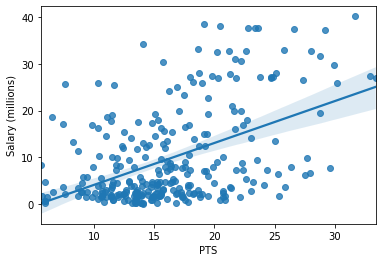

In [16]:
sns.regplot(x='PTS', y='Salary (millions)', data=df);

Now it's time to identify the other important stats to eventually include in the model.  A correlation map can be used to look at the top 10.

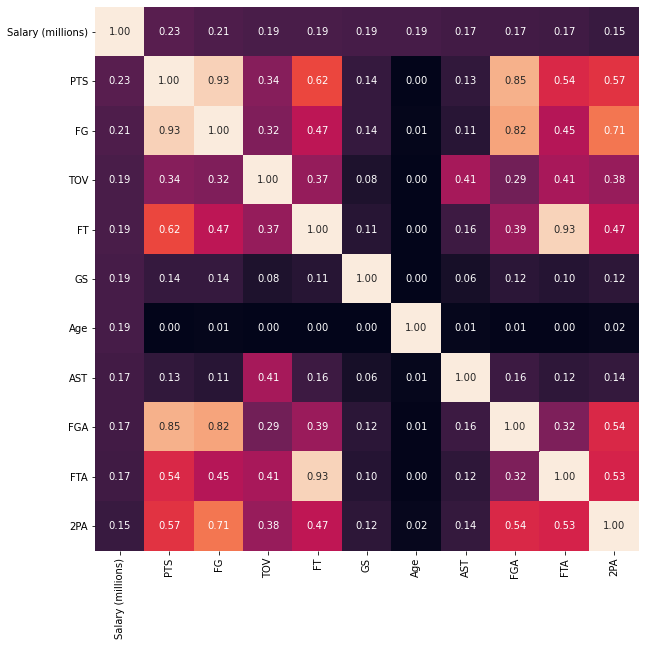

In [17]:
corr = df.corr()
r2 = corr ** 2
n = 11
cols = r2.nlargest(n, 'Salary (millions)')['Salary (millions)'].index
cm = df[cols].corr()
cm_square = cm ** 2
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm_square, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
           xticklabels=cols.values)
plt.show()

The heatmap shows the top 10 stats correlated to salary.  None of them have a particulary high correlation.  The next step is cutting down the stats that will be used since some of them describe the same or similar things.  Similar stats here are PTS, FG, FGA, 2PA, FT, and FTA, which all ultimately relate to how many points a player scores.

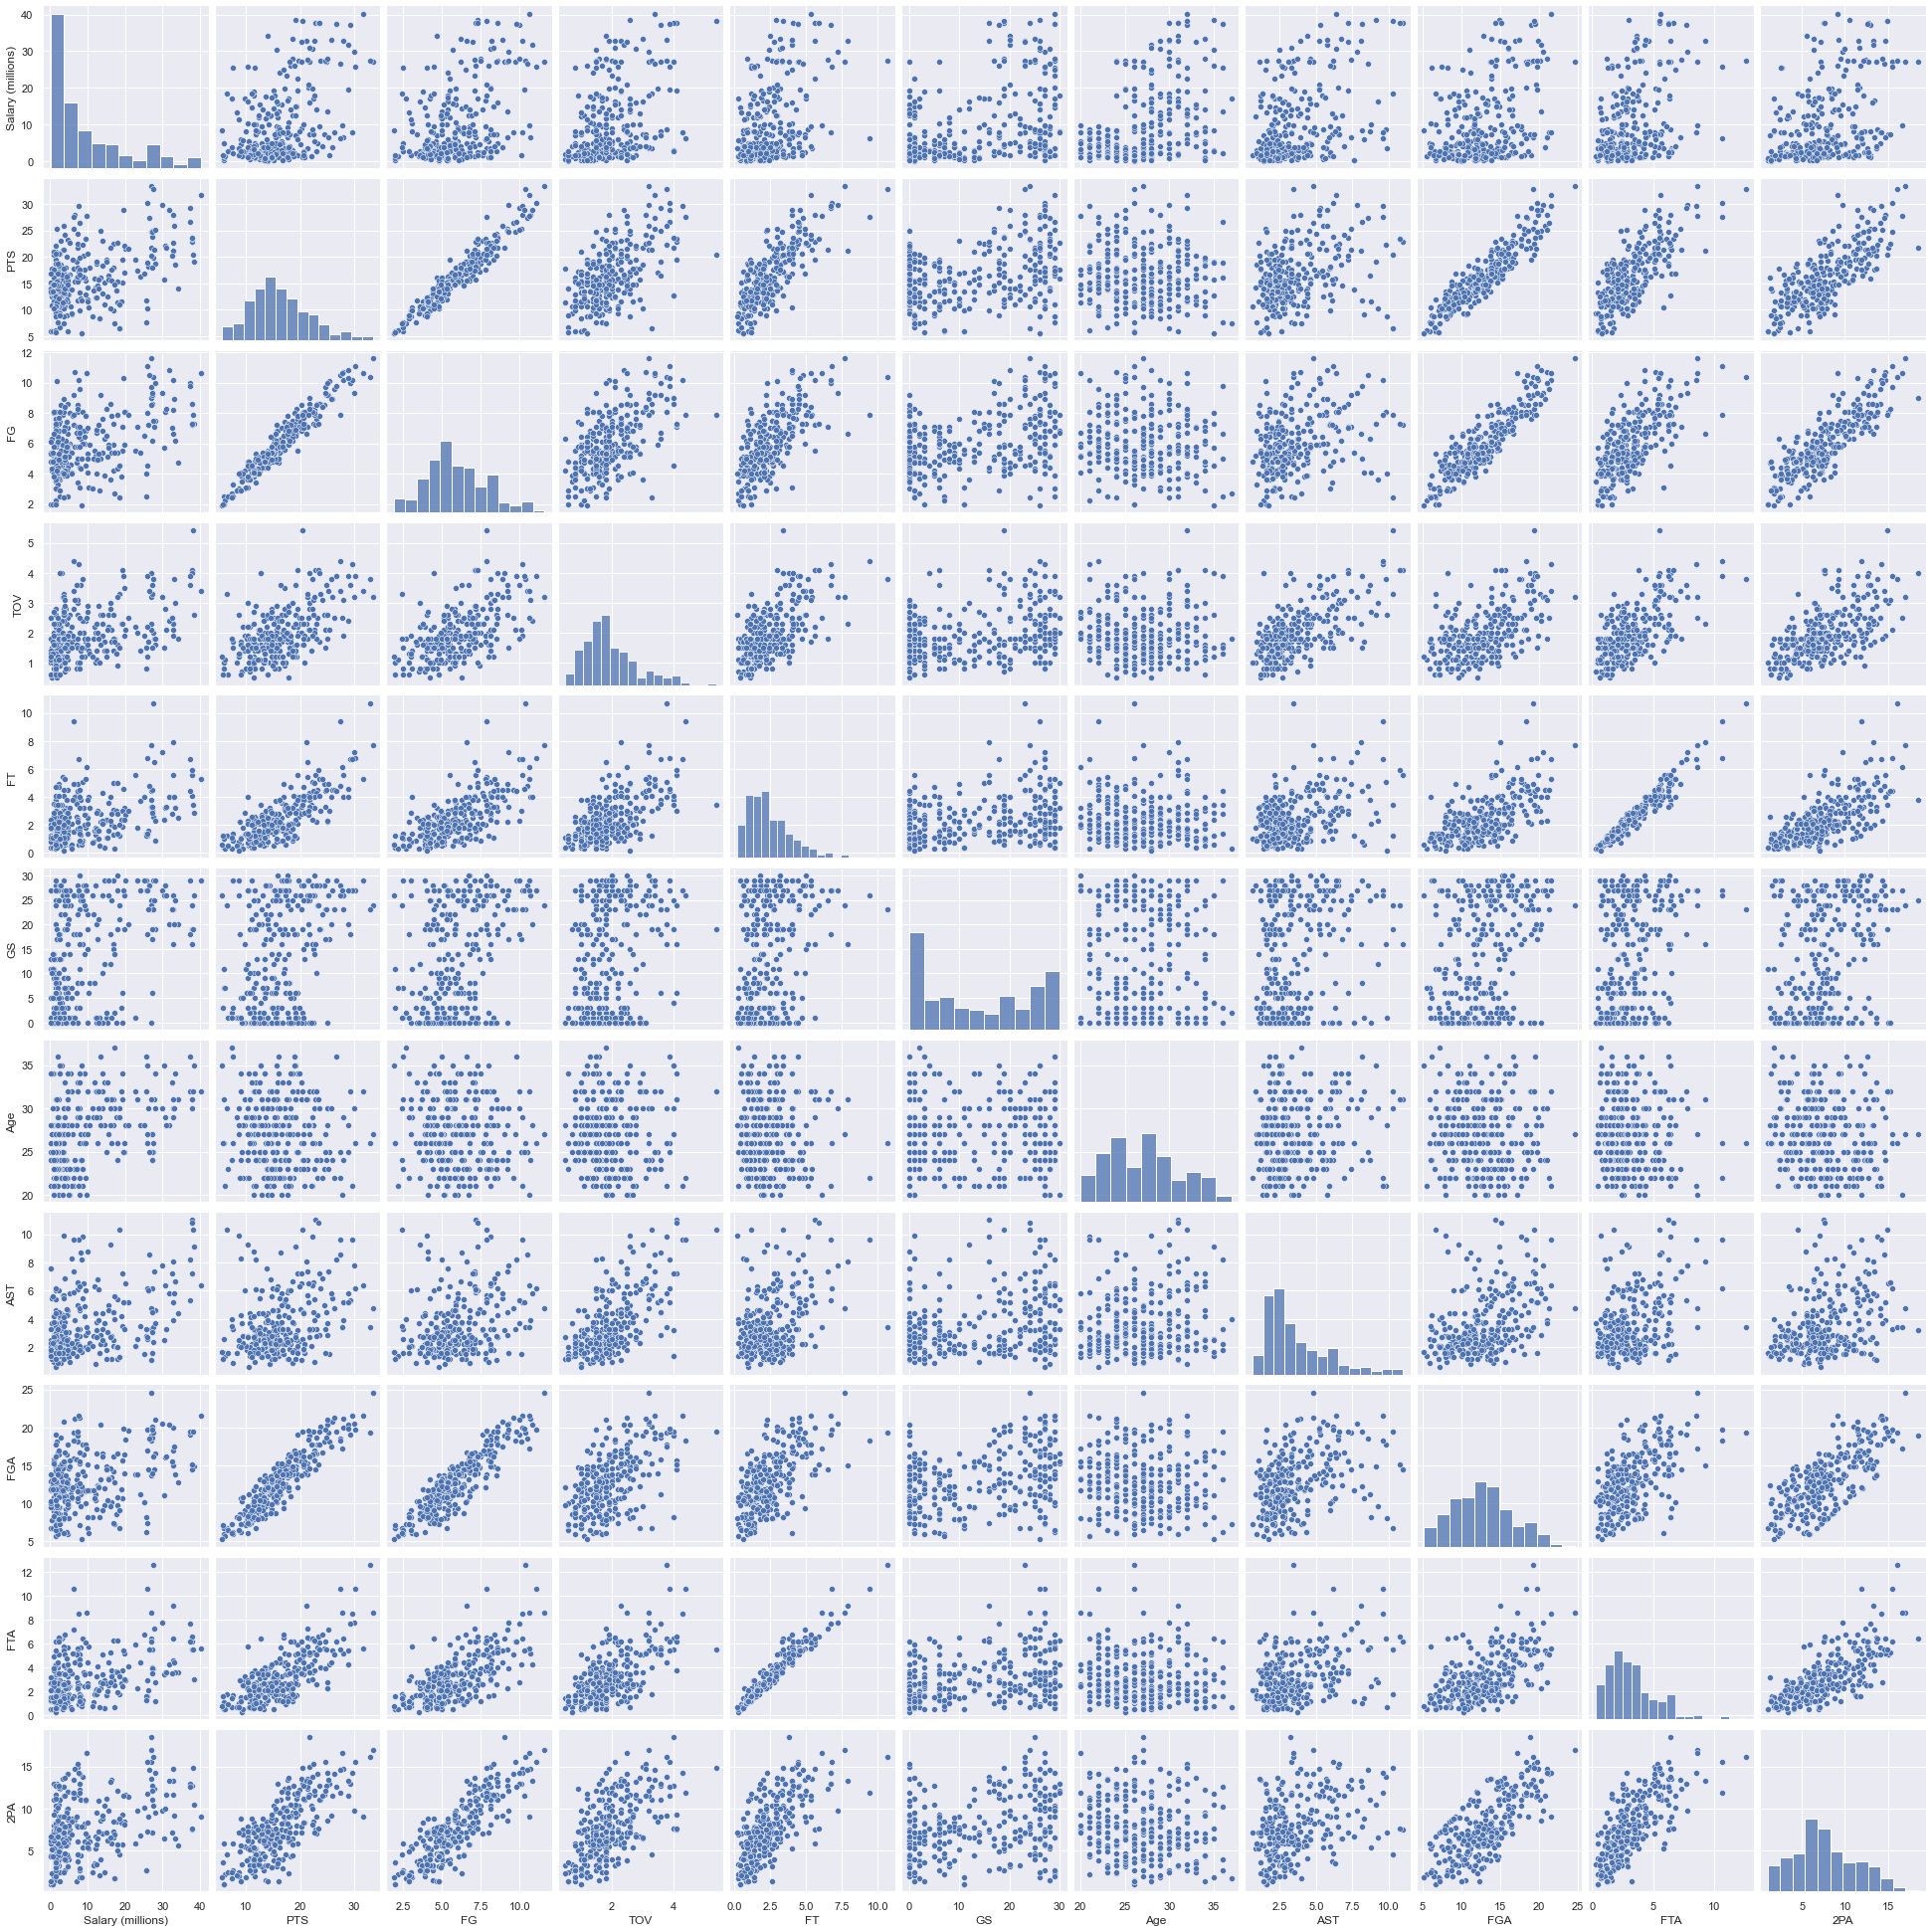

In [18]:
stats = ['Salary (millions)', 'PTS', 'FG', 'TOV', 'FT', 'GS', 'Age', 'AST', 'FGA', 'FTA', '2PA']

sns.set()
sns.pairplot(df[stats], height = 2.5)
plt.show()

Now that it has been verified that certain stats are collinear, some of the top 10 can be eliminated.  When the model is being created the stats PTS, TOV, GS, Age, and AST.

Now the categorical features must be explored.

In [19]:
# Take a closer look at the types of Signings
df['Signed Using'].unique()

array(['Bird Rights', '1st Round Pick', 'Cap Space', 'Minimum Salary',
       'Room Exception', 'Non-Bird Exception', '1st Round pick', 'MLE',
       'Early Bird Rights', 'Unknown', 'Sign and Trade', 'Cap space',
       '1st round pick', 'MInimum Salary', 'DPE', 'Maximum Salary',
       'Bi-annual Exception'], dtype=object)

In [20]:
# Clean up the entries
df['Signed Using'] = df['Signed Using'].replace(['Bird Rights', '1st Round pick', '1st round pick', 'MInimum Salary', 'Cap space'],
                                               ['Early Bird Rights', '1st Round Pick', '1st Round Pick', 'Minimum Salary', 'Cap Space'])

df['Signed Using'].unique()

array(['Early Bird Rights', '1st Round Pick', 'Cap Space',
       'Minimum Salary', 'Room Exception', 'Non-Bird Exception', 'MLE',
       'Unknown', 'Sign and Trade', 'DPE', 'Maximum Salary',
       'Bi-annual Exception'], dtype=object)

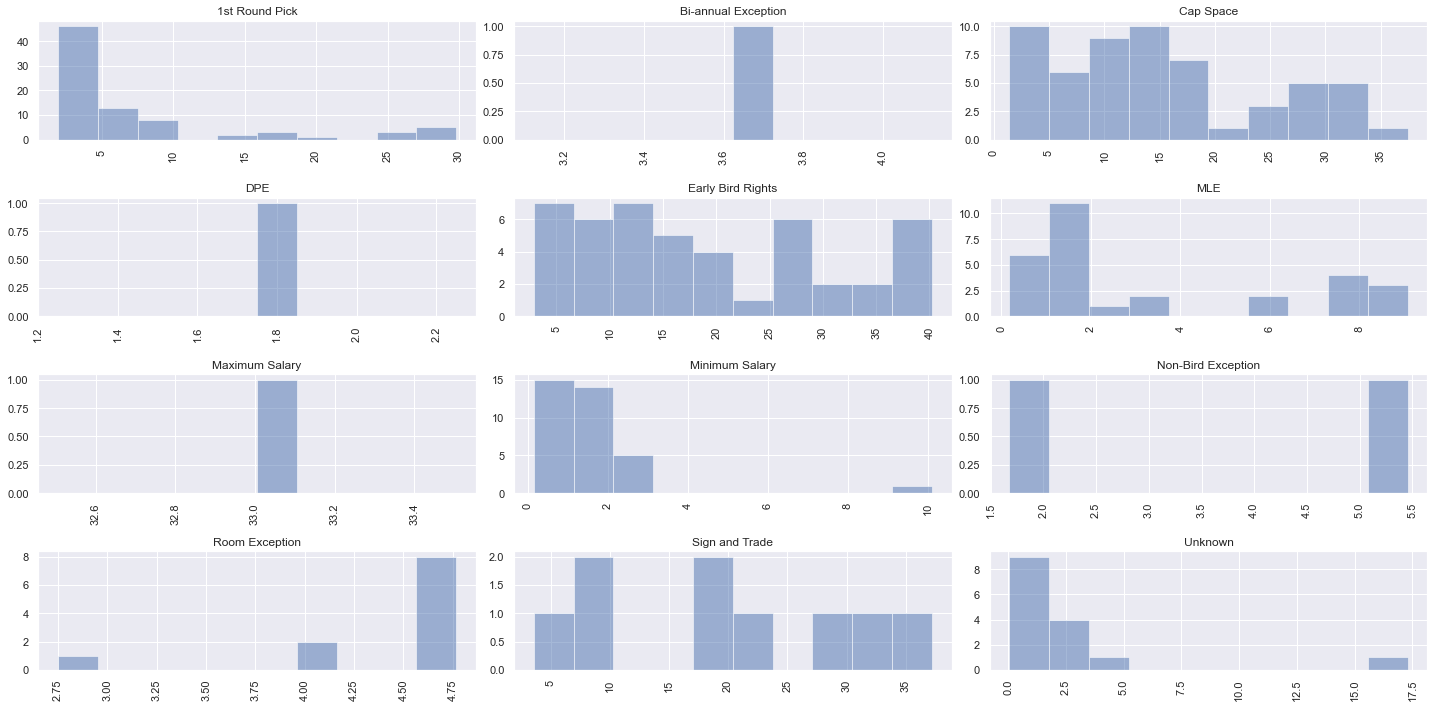

In [21]:
# Visualize the distribution of salaries depending on the type of signings
df['Salary (millions)'].hist(by=df['Signed Using'], alpha=0.5, figsize=(20,10));
plt.tight_layout();
plt.show()

The above histograms reveal something interesting.  There are more than 40 1st Round Picks with salaries less than 5 million.  Compared to the other types of signings, this distribution is the most skewed and, since these players are rookies, their salaries are small regardless of how well they play.  It may be useful to look at the key relationships without 1st Round Picks included since they make up most of the low salary blob that was seen in the inital regplots.

In [22]:
df = df[df['Signed Using'] != '1st Round Pick']
df['Signed Using'].unique()

array(['Early Bird Rights', 'Cap Space', 'Minimum Salary',
       'Room Exception', 'Non-Bird Exception', 'MLE', 'Unknown',
       'Sign and Trade', 'DPE', 'Maximum Salary', 'Bi-annual Exception'],
      dtype=object)

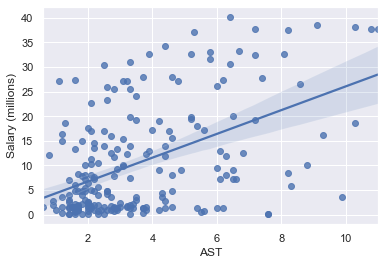

In [23]:
# Examine the relationship between salary and AST
sns.regplot(x='AST', y='Salary (millions)', data=df);

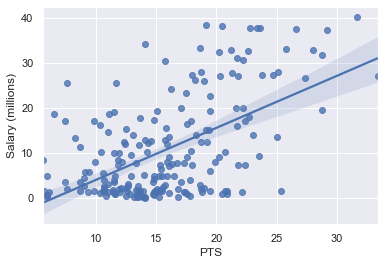

In [24]:
# Examine the relationship between salary and PTS
sns.regplot(x='PTS', y='Salary (millions)', data=df);

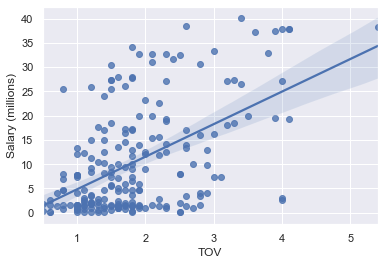

In [25]:
# Examine the relationship between salary and TOV
sns.regplot(x='TOV', y='Salary (millions)', data=df);

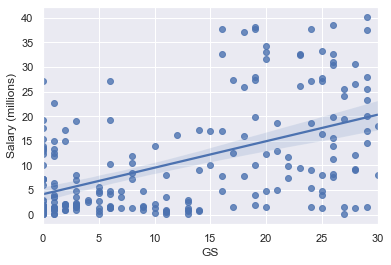

In [26]:
# Examine the relationship between salary and GS
sns.regplot(x='GS', y='Salary (millions)', data=df);

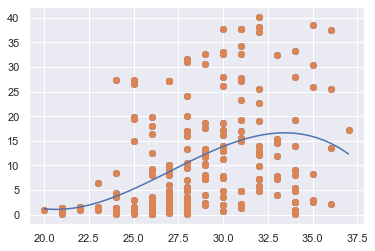

In [27]:
# Examine the relationship between age and salary, using some basic logic it can be assumed that this is not
# a linear relationship, since players are expected to earn the most during their prime years
x = df['Age']
y = df['Salary (millions)']
plt.scatter(x, y);

poly = np.poly1d(np.polyfit(x, y, 3))
line = np.linspace(20, 37, 40)

plt.scatter(x, y)
plt.plot(line, poly(line))
plt.show()

In [28]:
# Some modifications were made to the dataframe in this notebook, so a new version will be saved for future use
df.to_csv('NBA data for preprocessing')